<a href="https://colab.research.google.com/github/allan-jt/IJEPA-Thermal-Benchmark/blob/notebook/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries



In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [2]:
import requests
from PIL import Image
from torch.nn.functional import cosine_similarity
from transformers import AutoModel, AutoProcessor

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Basic test of I-JEPA's context encoder

In [ ]:
model_id = "facebook/ijepa_vith14_22k"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

In [ ]:
url_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_2 = "http://images.cocodataset.org/val2017/000000219578.jpg"
image_1 = Image.open(requests.get(url_1, stream=True).raw)
image_2 = Image.open(requests.get(url_2, stream=True).raw)

In [ ]:
img_processed = processor(image_1, return_tensors="pt")
output = model(**img_processed)
# print(output.pooler_output.shape)

In [ ]:
print(output.last_hidden_state[:, 0, :].shape)

torch.Size([1, 1280])


In [ ]:
def infer(image):
    inputs = processor(image, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [ ]:
embed_1 = infer(image_1)
embed_2 = infer(image_2)

In [ ]:
similarity = cosine_similarity(embed_1, embed_2)
print(similarity)

tensor([0.5071], grad_fn=<SumBackward1>)


# Data Loader

In [26]:
import kagglehub
path = kagglehub.dataset_download("breejeshdhar/thermal-image-dataset-for-object-classification")

100%|██████████| 3.24G/3.24G [02:30<00:00, 23.1MB/s]

Extracting files...


In [32]:
import os
!mv {path} {os.getcwd()}

In [34]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [113]:
from PIL import ImageOps

In [129]:
def fix_exif_orientation(image):
    return ImageOps.exif_transpose(image)

transform = transforms.Compose([
    transforms.Lambda(fix_exif_orientation),
    transforms.Resize((400, 300)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
])

In [130]:
# Load the dataset
# The test and train folder should follow their orginal structure where there are 3 subfolders, one for each class
train_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Test', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Train', transform=transform)

In [131]:
# Define split ratios
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
torch.manual_seed(42)  # Set seed for reproducibility
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [132]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [133]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Testing data size: {len(test_dataset)}")
print(train_dataset.class_to_idx)

Train data size: 854
Validation data size: 214
Testing data size: 4732
{'car': 0, 'cat': 1, 'man': 2}


Batch image shape: torch.Size([32, 3, 400, 300])
Batch labels: tensor([0, 2, 0, 1, 2, 0, 1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 1, 2, 2, 2, 0, 0, 1,
        1, 0, 0, 0, 2, 2, 1, 2])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.9961, 0.9961, 0.9961,  ..., 0.0000, 0.0000, 0.0039],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.9961, 0.9961],
         [0.0000, 0.0000, 0.0000,  ..., 0.9961, 0.9961, 0.9961]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.4039, 0.4275, 0.4392],
         [0.9961, 0.9961, 0.9961,  ..., 0.4118, 0.4353, 0.4471],
         [0.9961, 0.9961, 0.9961,  ..., 0.4235, 0.4471, 0.4627],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2549, 0.2235, 0.2078],
         [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.1412, 0.0941],
         [0.0000, 0.0000, 0.0000,  ..., 0.2078, 0.0824, 0.0196]],

        [[1.

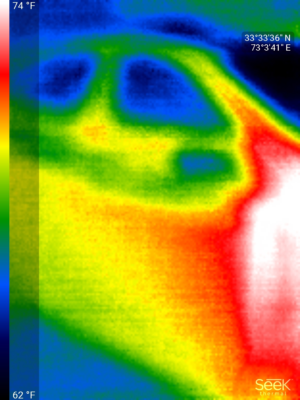

In [134]:
# Verify a batch from train_loader
from PIL import Image
from IPython.display import display
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Example: [32, 3, 300, 400]
    print(f"Batch labels: {labels}")            # Example: tensor([0, 1, ...])
    print(images[0])
    print(labels[0])

    image = images[0].permute((1, 2, 0)).numpy()
    print(image.shape)

    # Matplot version
    # plt.imshow(image)
    # plt.title(f"Label: {labels[0].item()}")  # Display the label of the first image
    # plt.axis('off')  # Turn off axis labels
    # plt.show()

    # Python PIL version
    # Convert the numpy array to a PIL Image
    image_pil = Image.fromarray((image * 255).astype('uint8'))  # Convert to 8-bit image (values 0-255)
    display(image_pil)
    break

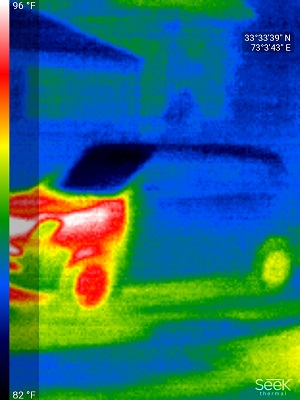

In [135]:
# Specify the image path
image_path = '/content/1/Thermal Image Dataset/SeekThermal/Test/car/003.jpg'

# Open the image using PIL
image = Image.open(image_path)
# Show the image
display(image)

# Loading Backbone

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5, activation=nn.ReLU):
        super(ClassificationHead, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.num_classes = output_dim
        self.dropout_rate = dropout_rate

        layers = []
        dims = [input_dim] + hidden_dims

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.LayerNorm(dims[i+1]))
            layers.append(activation())
            layers.append(nn.Dropout(dropout_rate))

        # Add the final output layer
        layers.append(nn.Linear(dims[-1], self.num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class TransformerWithClassificationHead(nn.Module):
    def __init__(self, vit, hidden_dims, output_dim, dropout_rate=0.5, activation=nn.ReLU, withLayerNorm=False):
        super(TransformerWithClassificationHead, self).__init__()
        self.vit = vit
        self.layer_norm = None
        if withLayerNorm:
            self.layer_norm = nn.LayerNorm(self.vit.config.hidden_size)
        self.classification_head = ClassificationHead(
            self.vit.config.hidden_size,
            hidden_dims,
            output_dim,
            dropout_rate,
            activation
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]
        if self.layer_norm is not None:
          cls_token = self.layer_norm(cls_token)
        return self.classification_head(cls_token)

In [ ]:
# Test
model_with_classifier = TransformerWithClassificationHead(
    model,
    [10],
    3,
    dropout_rate=0.5,
    activation=nn.ReLU,
    withLayerNorm=False
)

In [ ]:
output = model_with_classifier(**img_processed)
print(output)

tensor([[-0.4896,  0.5661,  0.6515]], grad_fn=<AddmmBackward0>)
